In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import gamma

%matplotlib inline

# Discounted integral 'Voting'

Simple model proposed for implementing and testing a voting scheme

- Assume a dynamic supply of governance tokens accessed by a bonding ETH (linear bonding curve)
- Assume this tokens also represent a stake in a revenue generating process
- The revenue generating process is has one parameter which is "governed" 
- The revenue generated is random and there is a true "best parameter" unknown to the voters which may change
- The goal of the 'voting' system is for the selected parameter to track the "best parameter"
- In this set up, voting is completely passive, "votes" are automatically determined by each agents belief state and counted according to their balance of the 'Tokens' that representing their voting capacity
- These tokens also represent their stake in the pool of Ether being generated by the revenue process

This is a sensor fusion problem -- coordination problem. The environment, the pool of agents, the process, the actions and the system updates have been made mind-numbingly noisy in order to show the effect of the di

In [2]:
#Define the Revenue generating process
def revenue(true_best_param,current_voted_param ):
    #use an concave function with unique maximum as true_best_param = current_voted_param
    base_scale = 1
    scale = base_scale*np.exp(-(true_best_param-current_voted_param)**2)
    shape = .5
    return gamma(scale, shape).rvs()

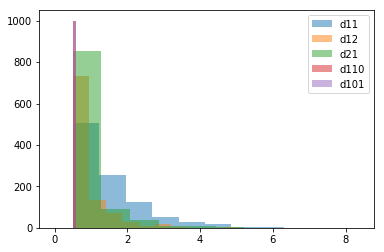

In [3]:
#test the revenue random variable as a function of how right the param is
N = 1000
bins = 10
d11=np.zeros(N)
d12=np.zeros(N)
d21=np.zeros(N)
d110=np.zeros(N)
d101=np.zeros(N)
for i in range(N):
    d11[i] = revenue(1,1)
    d12[i] = revenue(1,2)
    d21[i] = revenue(2,1)
    d110[i] = revenue(1,10)
    d101[i] = revenue(10,1)

plt.hist(d11, bins, alpha=0.5, label='d11')
plt.hist(d12, bins, alpha=0.5, label='d12')
plt.hist(d21, bins, alpha=0.5, label='d21')
plt.hist(d110, bins, alpha=0.5, label='d110')
plt.hist(d101, bins, alpha=0.5, label='d101')

plt.legend(loc='upper right')
plt.show()

In [4]:
#Lets assuming that all tokens in existence is given by T

def bond_mint(eth, Eth, Tokens):
    return eth*Tokens/Eth

def burn_withdraw(tokens, Eth, Tokens):
    return tokens*Eth/Tokens


In [5]:
#define a set of agents
agents = {}

#for simplicity we just assume that any tokens owned a staked to vote
def add_agent(eth, tbparam, Eth, Tokens):
    agents[str(len(agents))] = {"eth":eth,
                           "tokens":0,
                           "param_belief": 2*tbparam*np.random.uniform(),
                           "value_belief":2*Tokens/Eth*np.random.uniform()}
    

def agent_acts(a, Eth, Tokens, r, p):
    #update value belief
    agents[a]["value_belief"] = 2*Tokens/Eth*np.random.uniform()
    
    #update tokens held -- buy or sell -- pretty naive with random belief and random amount
    if agents[a]["value_belief"]<Tokens/Eth:
        urv =np.random.uniform() 
        burn = agents[a]["tokens"]*urv
        eth_out = burn_withdraw(burn, Eth, Tokens)
        
        agents[a]["tokens"] = agents[a]["tokens"]-burn
        agents[a]["eth"] = agents[a]["eth"] + eth_out
        Tokens = Tokens - burn
        Eth = Eth - eth_out
        
    else:
        
        urv =np.random.uniform() 
        bond =agents[a]["eth"]*urv
        mint = bond_mint(bond, Eth, Tokens)
        
        agents[a]["tokens"] = agents[a]["tokens"]+mint
        agents[a]["eth"] = agents[a]["eth"] -bond
        Tokens = Tokens + mint
        Eth = Eth + bond
        
    #update believe by taking a tiny step along slope of observations
    
    agents[a]["param_belief"] = np.max([0,agents[a]["param_belief"] + np.random.uniform()*np.polyfit(p, r, 1)[0]])

    #print(agents[a]["value_belief"])
    return Eth, Tokens, agents[a]




In [6]:
K= 30000
alpha=.95 #forgetfulness
true_best_param = 5*np.ones(K) 
#throw a step change in there to mix things up
#true_best_param[:int(K/2)] =.5*true_best_param[:int(K/2)]


E=np.zeros(K)
T=np.zeros(K)

Eth =1
Tokens =100
E[0] = Eth
T[0] = Tokens

agents = {}
add_agent(gamma(5,1).rvs(), true_best_param[0], Eth, Tokens)

votes=np.zeros(K)
count=np.zeros(K)
param=np.zeros(K)
rev=np.zeros(K)

n = np.zeros(K)
n[0]=1

for k in range(1,K):
    Eth = E[k-1]
    Tokens = T[k-1]
    #resolve governance -- what is the belief of the param
    votes[k] = (np.sum([agents[a]["tokens"]*agents[a]["param_belief"] for a in list(agents.keys())])+ alpha*votes[k-1])
    count[k] = (np.sum([agents[a]["tokens"] for a in list(agents.keys())])+ alpha*count[k-1])
    if count[k]>0:
        param[k] = votes[k]/count[k]
    else:
        param[k] = 1
    rev[k] = revenue(true_best_param[k],param[k])
    Eth = Eth+rev[k]
    
    #new agents join
    if np.random.uniform()< np.log10(K/k):
        new = int(2*np.random.uniform())
        for i in range(new):
            add_agent(gamma(5,1).rvs(), true_best_param[k], Eth, Tokens)
    n[k]=len(agents)
        
    #pick some to update on the order of log of agents
    active = random.sample(list(agents.keys()), int(np.log2(len(agents))))
    for a in active:
        Eth, Tokens, val = agent_acts(a, Eth, Tokens, rev[:k+1], param[:k+1])
        agents[a] = val
        
    E[k] = Eth
    T[k] = Tokens
    

In [7]:
k

29999

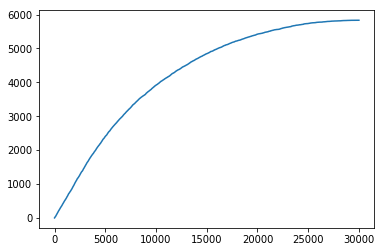

In [8]:
plt.plot(range(K),n)

(array([1.5019e+04, 1.0267e+04, 3.2000e+03, 1.0190e+03, 3.3800e+02,
        1.0400e+02, 3.6000e+01, 9.0000e+00, 5.0000e+00, 3.0000e+00]),
 array([ 0.        ,  1.09558229,  2.19116458,  3.28674686,  4.38232915,
         5.47791144,  6.57349373,  7.66907602,  8.76465831,  9.86024059,
        10.95582288]),
 <a list of 10 Patch objects>)

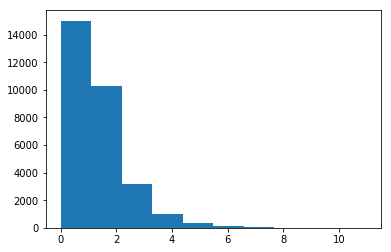

In [9]:
plt.hist(rev)

(array([2.00000000e+00, 5.00000000e-01, 1.50000179e+00, 5.00000000e-01,
        5.00000001e-01, 5.01052386e-01, 1.61778462e+01, 2.68853863e+03,
        8.20332653e+03, 9.16435732e+03, 2.14804582e+04, 3.49353597e+02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array([-3.01701255, -2.69633204, -2.37565154, -2.05497104, -1.73429054,
        -1.41361004, -1.09292954, -0.77224903, -0.45156853, -0.13088803,
         0.18979247,  0.51047297,  0.83115348,  1.15183398,  1.47251448,
         1.79319498,  2.11387548,  2.43455599,  2.75523649,  3.07591699,
         3.39659749,  3.71727799,  4.03795849,  4.358639  ,  4.6793195 ,
         5.        ]),
 <a list of 25 Patch objects>)

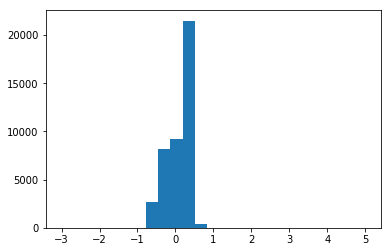

In [10]:
plt.hist(true_best_param-param, weights = rev, bins=25)

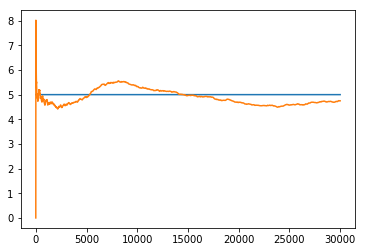

In [11]:
plt.plot(range(K), true_best_param, range(K), param )

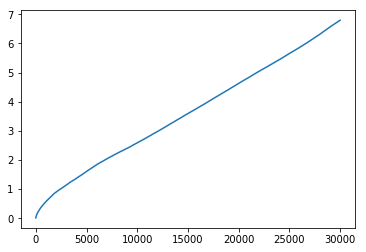

In [12]:
plt.plot(range(K), E/T)

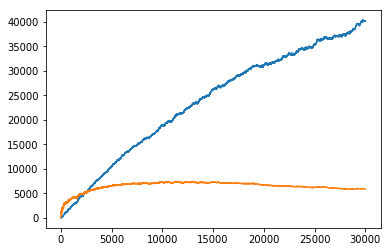

In [13]:
plt.plot(range(K), E, range(K), T)

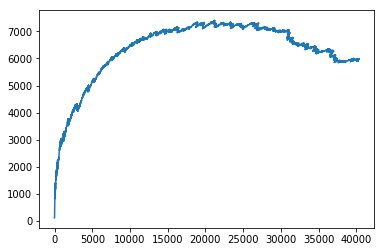

In [16]:
plt.plot(E, T)

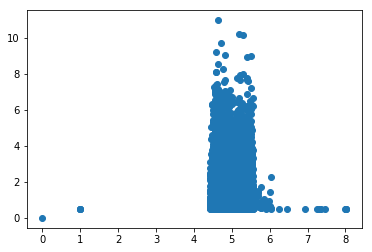

In [18]:
plt.scatter(param,rev)

[4, 6, 0, 4]

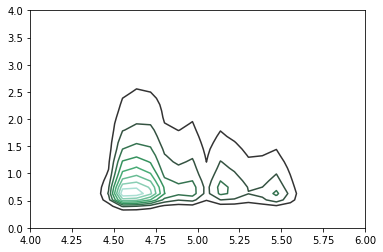

In [20]:
sns.kdeplot(param,rev)
plt.axis([4,6,0,4])

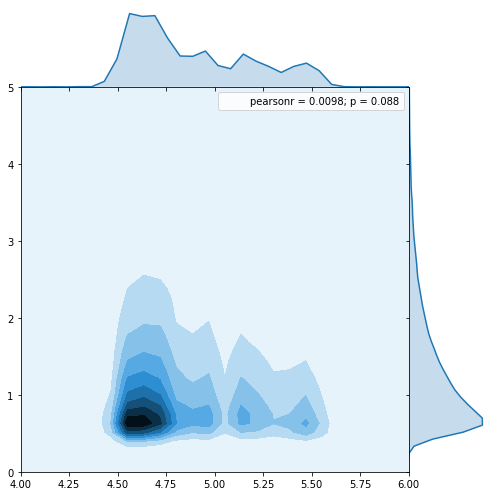

In [22]:
sns.jointplot(param, rev, kind="kde", size=7, space=0, xlim=[4,6],ylim=[0,5])